# Settings

In [1]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [2]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, Matrix,forcats,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX, HGNChelper, openxlsx, cluster,
               logr, parallel, future,
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

In [3]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

# set Future
plan("multicore", workers = 4)
# set RAM treshold
## 1000 = 1gb
RAM.tresh = 10000 * 1024^2
options(future.globals.maxSize = RAM.tresh)

In [4]:
# Set directories
fastq.dir = "/nfs/lab/projects/COVID_mouse/raw_data/230616_A01535_0344_BH7LF2DSX7_2/"
base.dir = "/nfs/lab/projects/COVID_mouse/"
assets.dir = "/nfs/lab/projects/COVID_mouse/assets/"
cell.ranger.dir = paste(base.dir, "cell.ranger/", sep = "")
seurat.dir = paste(base.dir, "seurat/", sep = "")
step1.dir = paste(seurat.dir, "1_pre.processing/", sep = "")
step2.dir = paste(seurat.dir, "2_SoupX/", sep = "")
step3.dir = paste(seurat.dir, "3_scrublet/", sep = "")
step4.dir = paste(seurat.dir, "4_merge.samples/", sep = "")
step5.dir = paste(seurat.dir, "5_clean.map/", sep = "")

In [5]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "Cell.markers_4.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]
compartment.ls = unique(cell.markers$Compartment)
celltype.ls = unique(cell.markers$Celltype)
# Factorize columns
cell.markers$Compartment = factor(cell.markers$Compartment, 
                        levels = compartment.ls)
cell.markers$CellType = factor(cell.markers$Celltype,
                        levels = celltype.ls)

# Load data

In [6]:
adata = readRDS(paste(step4.dir, "snRNAseq_mrg.clean.rds", sep = ""))

In [7]:
adata

An object of class Seurat 
86047 features across 116182 samples within 3 assays 
Active assay: SCT (21477 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: RNA, RNA_raw
 3 dimensional reductions calculated: pca, harmony, umap

In [8]:
# load gene set preparation function
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/gene_sets_prepare.R")
# load cell type annotation function
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/sctype_score_.R")

In [9]:
adata <- ScaleData(adata, features = rownames(adata))

Centering and scaling data matrix



In [10]:
gs_list = gene_sets_prepare("/nfs/lab/projects/COVID_mouse/assets/jaesudata_markergenes_nov15.xlsx", c("Bone marrow"))
# gs_list = gene_sets_prepare("/nfs/lab/projects/COVID_mouse/assets/ScTypeDB_Immune.xlsx", c("Immune system"))

In [11]:
es.max = sctype_score(scRNAseqData = adata[["SCT"]]@scale.data, scaled = TRUE, 
                      gs = gs_list$gs_positive, gs2 = gs_list$gs_negative) 

In [12]:
gs_list

$gs_positive
$gs_positive$`B cells precursor`
[1] "ANKRD33B" "EBF1"     "IGLL1"    "IL7R"     "NRGN"     "VPREB1"   "VPREB3"  
[8] "YBX3"    

$gs_positive$Monocytes
[1] "CCR2"   "CEBPB"  "CSF1R"  "F13A1"  "S100A4" "SLPI"  

$gs_positive$Neutrophils
 [1] "APOE"    "CAMP"    "CA1"     "NR1I3"   "CEBPE"   "CENPA"   "CENPF"  
 [8] "CTSG"    "ELANE"   "H2AC4"   "H3C6"    "LCN2"    "LTB"     "MKI67"  
[15] "MS4A3"   "NUSAP1"  "PGLYRP1" "RGCC"    "S100A8"  "S100A9"  "UBE2C"  

$gs_positive$`T cells`
 [1] "BCL11B" "CD2"    "CD28"   "CD3D"   "CD3E"   "CD3G"   "CD52"   "CD8B"  
 [9] "GATA3"  "ID2"    "IL7R"   "JUNB"   "LAT"    "S100A4" "SKAP1"  "SOCS1" 
[17] "TRBC1"  "TRBC2" 

$gs_positive$`NK cells`
 [1] "CCL5"   "CD52"   "CTSW"   "GZMA"   "KLRB1"  "KLRD1"  "KLRK1"  "MALAT1"
 [9] "NCR1"   "NKG7"   "PTPRC"  "SKAP1"  "TYROBP" "XCL1"  

$gs_positive$`Dendritic cells`
[1] "CD74" "CD83" "CD86" "CST3" "IRF8"

$gs_positive$`B cells`
 [1] "BLNK"   "CD19"   "CD79A"  "CD79B"  "EBF1"   "FCRLA"  "H1-1"   "H1-5"  
 [9] "H1-4"   "H2AC8"  "H3C3"   "H4C4"   "H2AC20" "LY6D"   "TOP2A"  "VPREB3"

$gs_positive$Macrophages
 [1] "ADGRE1" "AOPEP"  "C1QA"   "C1QB"   "C1QC"   "CSF1R"  "CTSS"   "HMOX1" 
 [9] "MRC1"   "MS4A7"  "PF4"   

$gs_positive$Megakaryocyte
[1] "ITGA2B" "ITGB3"  "PF4"    "PLEK"   "VWF"   

$gs_positive$`Erythroid cell`
 [1] "ALAD"  "ALAS2" "CA2"   "NR1I4" "DUT"   "ERMAP" "GMNN"  "HELLS" "LIG1" 
[10] "MCM3"  "MCM4"  "MCM7"  "NASP"  "PCNA"  "RHD"   "UHRF1"

$gs_positive$Basophil
[1] "ALOX15"  "CPA3"    "IL6"     "RNASE12" "STX3"   

$gs_positive$HSC
 [1] "ADGRG1"   "ADGRL4"   "CDKN1C"   "CLEC1A"   "DIPK1B"   "GCNT2"   
 [7] "HACD4"    "HLF"      "IFITM1"   "IFITM3"   "LMO2"     "LTB"     
[13] "MALAT1"   "MECOM"    "MLLT3"    "MMRN1"    "MPL"      "MSI2"    
[19] "MYCT1"    "PDZK1IP1" "PIM1"     "PROCR"    "PTPN18"   "RPS14"   
[25] "SULT1A1"  "TBXAS1"   "TMEM176A" "UBA7"    

$gs_positive$MEP
 [1] "APOE"     "AQP1"     "ATP5IF1"  "BLVRB"    "CA1"      "NR1I3"   
 [7] "C1QTNF12" "GCLM"     "GSTM5"    "KLF1"     "MT2A"     "TMPRSS6" 
[13] "TSPO2"    "VAMP5"   

$gs_positive$GMP
 [1] "ANXA1"   "CAMP"    "CD52"    "CTSG"    "ELANE"   "FCER1G"  "HP"     
 [8] "LCN2"    "LTF"     "MPO"     "MS4A3"   "PGLYRP1" "PRTN3"   "S100A6" 
[15] "S100A8"  "S100A9"  "SLPI"    "TYROBP" 

$gs_positive$MPPs
 [1] "CCND3"     "COX6A2"    "CR2"       "DNTT"      "DOCK2"     "EGFL7"    
 [7] "ELF4"      "FLT3"      "GPR171"    "MACROH2A1" "HPRT1"     "IL12A"    
[13] "LSP1"      "MSN"       "POU2F2"    "PTPRCAP"   "RAMP1"     "SATB1"    
[19] "SLAMF1"    "TCF4"      "TSC22D1"   "TSPAN13"  

$gs_positive$PreNeu
[1] "DMKN"    "HSD17B1" "VCAM1"  

$gs_positive$`Imm Neu`
[1] "CHIT1"  "DMC1"   "KBTBD6" "ORM1"  

$gs_positive$`Mature Neu`
 [1] "ABCA13" "ADAM8"  "C3"     "CD177"  "FPR1"   "GPR27"  "INHBA"  "MMP8"  
 [9] "MMP9"   "THBS1" 


$gs_negative
$gs_negative$`B cells precursor`
character(0)

$gs_negative$Monocytes
character(0)

$gs_negative$Neutrophils
character(0)

$gs_negative$`T cells`
character(0)

$gs_negative$`NK cells`
character(0)

$gs_negative$`Dendritic cells`
character(0)

$gs_negative$`B cells`
character(0)

$gs_negative$Macrophages
character(0)

$gs_negative$Megakaryocyte
character(0)

$gs_negative$`Erythroid cell`
character(0)

$gs_negative$Basophil
character(0)

$gs_negative$HSC
character(0)

$gs_negative$MEP
character(0)

$gs_negative$GMP
character(0)

$gs_negative$MPPs
character(0)

$gs_negative$PreNeu
character(0)

$gs_negative$`Imm Neu`
character(0)

$gs_negative$`Mature Neu`
character(0)

In [13]:
# merge by cluster
cL_resutls = do.call("rbind", lapply(unique(adata@meta.data$seurat_clusters), function(cl){
    es.max.cl = sort(rowSums(es.max[ ,rownames(adata@meta.data[adata@meta.data$seurat_clusters==cl, ])]), decreasing = !0)
    head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(adata@meta.data$seurat_clusters==cl)), 10)
}))
sctype_scores = cL_resutls %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  


In [14]:
# set low-confident (low ScType score) clusters to "unknown"
sctype_scores$type[as.numeric(as.character(sctype_scores$scores)) < sctype_scores$ncells/4] = "Unknown"
print(sctype_scores[,1:3])

# A tibble: 100 × 3
# Groups:   cluster [100]
   cluster type              scores
   <fct>   <chr>              <dbl>
 1 42      GMP                3182.
 2 34      MPPs               5472.
 3 4       GMP                3010.
 4 57      GMP                1600.
 5 79      GMP                1067.
 6 6       Monocytes          6834.
 7 33      GMP                2365.
 8 24      Mature Neu         5190.
 9 20      B cells precursor 12492.
10 23      GMP                2435.
# ℹ 90 more rows


In [15]:
adata@meta.data$customclassif = ""
for(j in unique(sctype_scores$cluster)){
  cl_type = sctype_scores[sctype_scores$cluster==j,]; 
  adata@meta.data$customclassif[adata@meta.data$seurat_clusters == j] = as.character(cl_type$type[1])
}

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



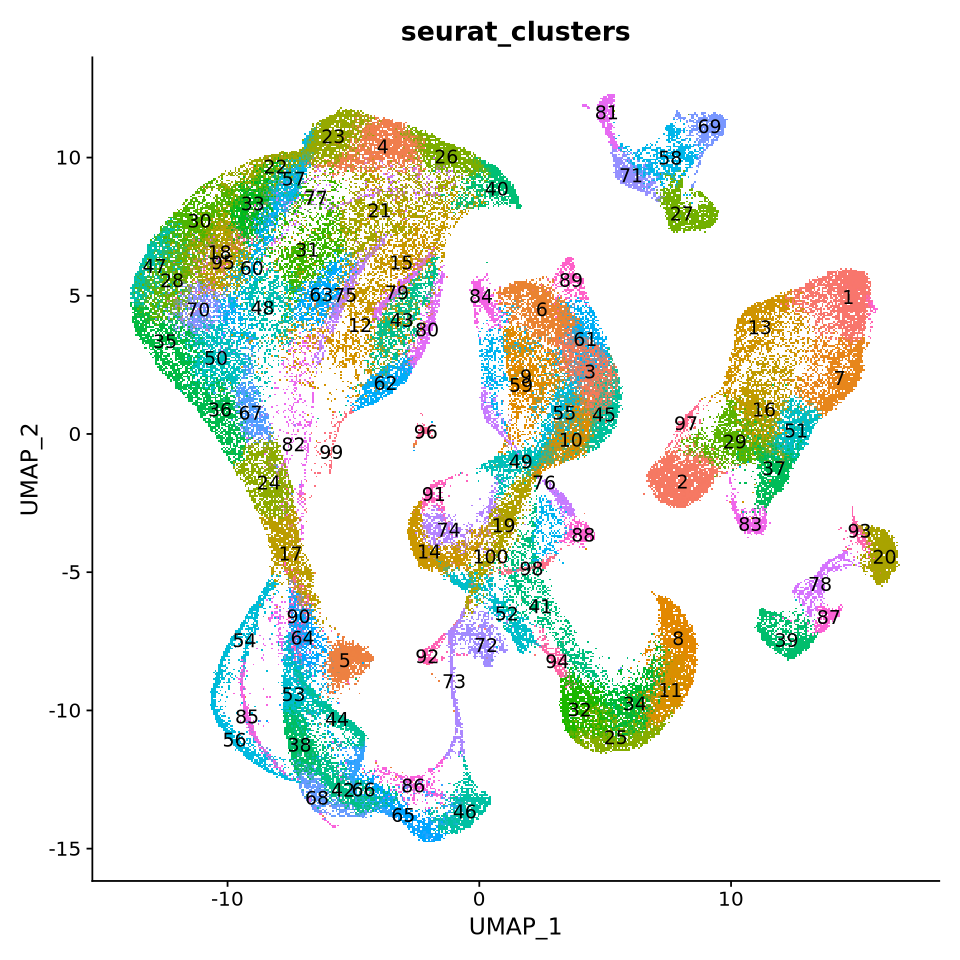

In [16]:
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(adata, reduction = "umap", label = TRUE,  group.by = 'seurat_clusters') + theme(legend.position = "none")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



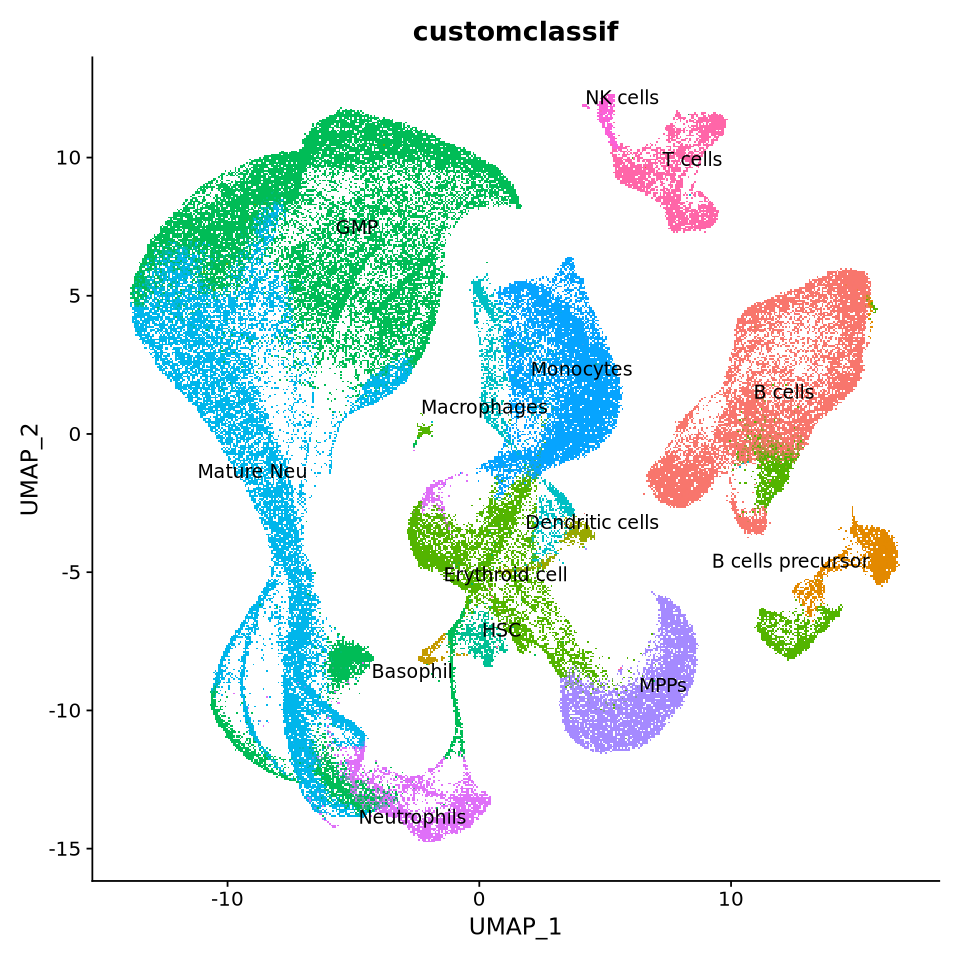

In [17]:
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(adata, reduction = "umap", label = TRUE, repel = TRUE, group.by = 'customclassif') + theme(legend.position = "none")

In [18]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "Cell.markers_4.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]
compartment.ls = unique(cell.markers$Compartment)
celltype.ls = unique(cell.markers$Celltype)
# Factorize columns
cell.markers$Compartment = factor(cell.markers$Compartment, 
                        levels = compartment.ls)
cell.markers$CellType = factor(cell.markers$Celltype,
                        levels = celltype.ls)

In [19]:
# Assign celltypes
Idents(object = adata) <- adata$customclassif

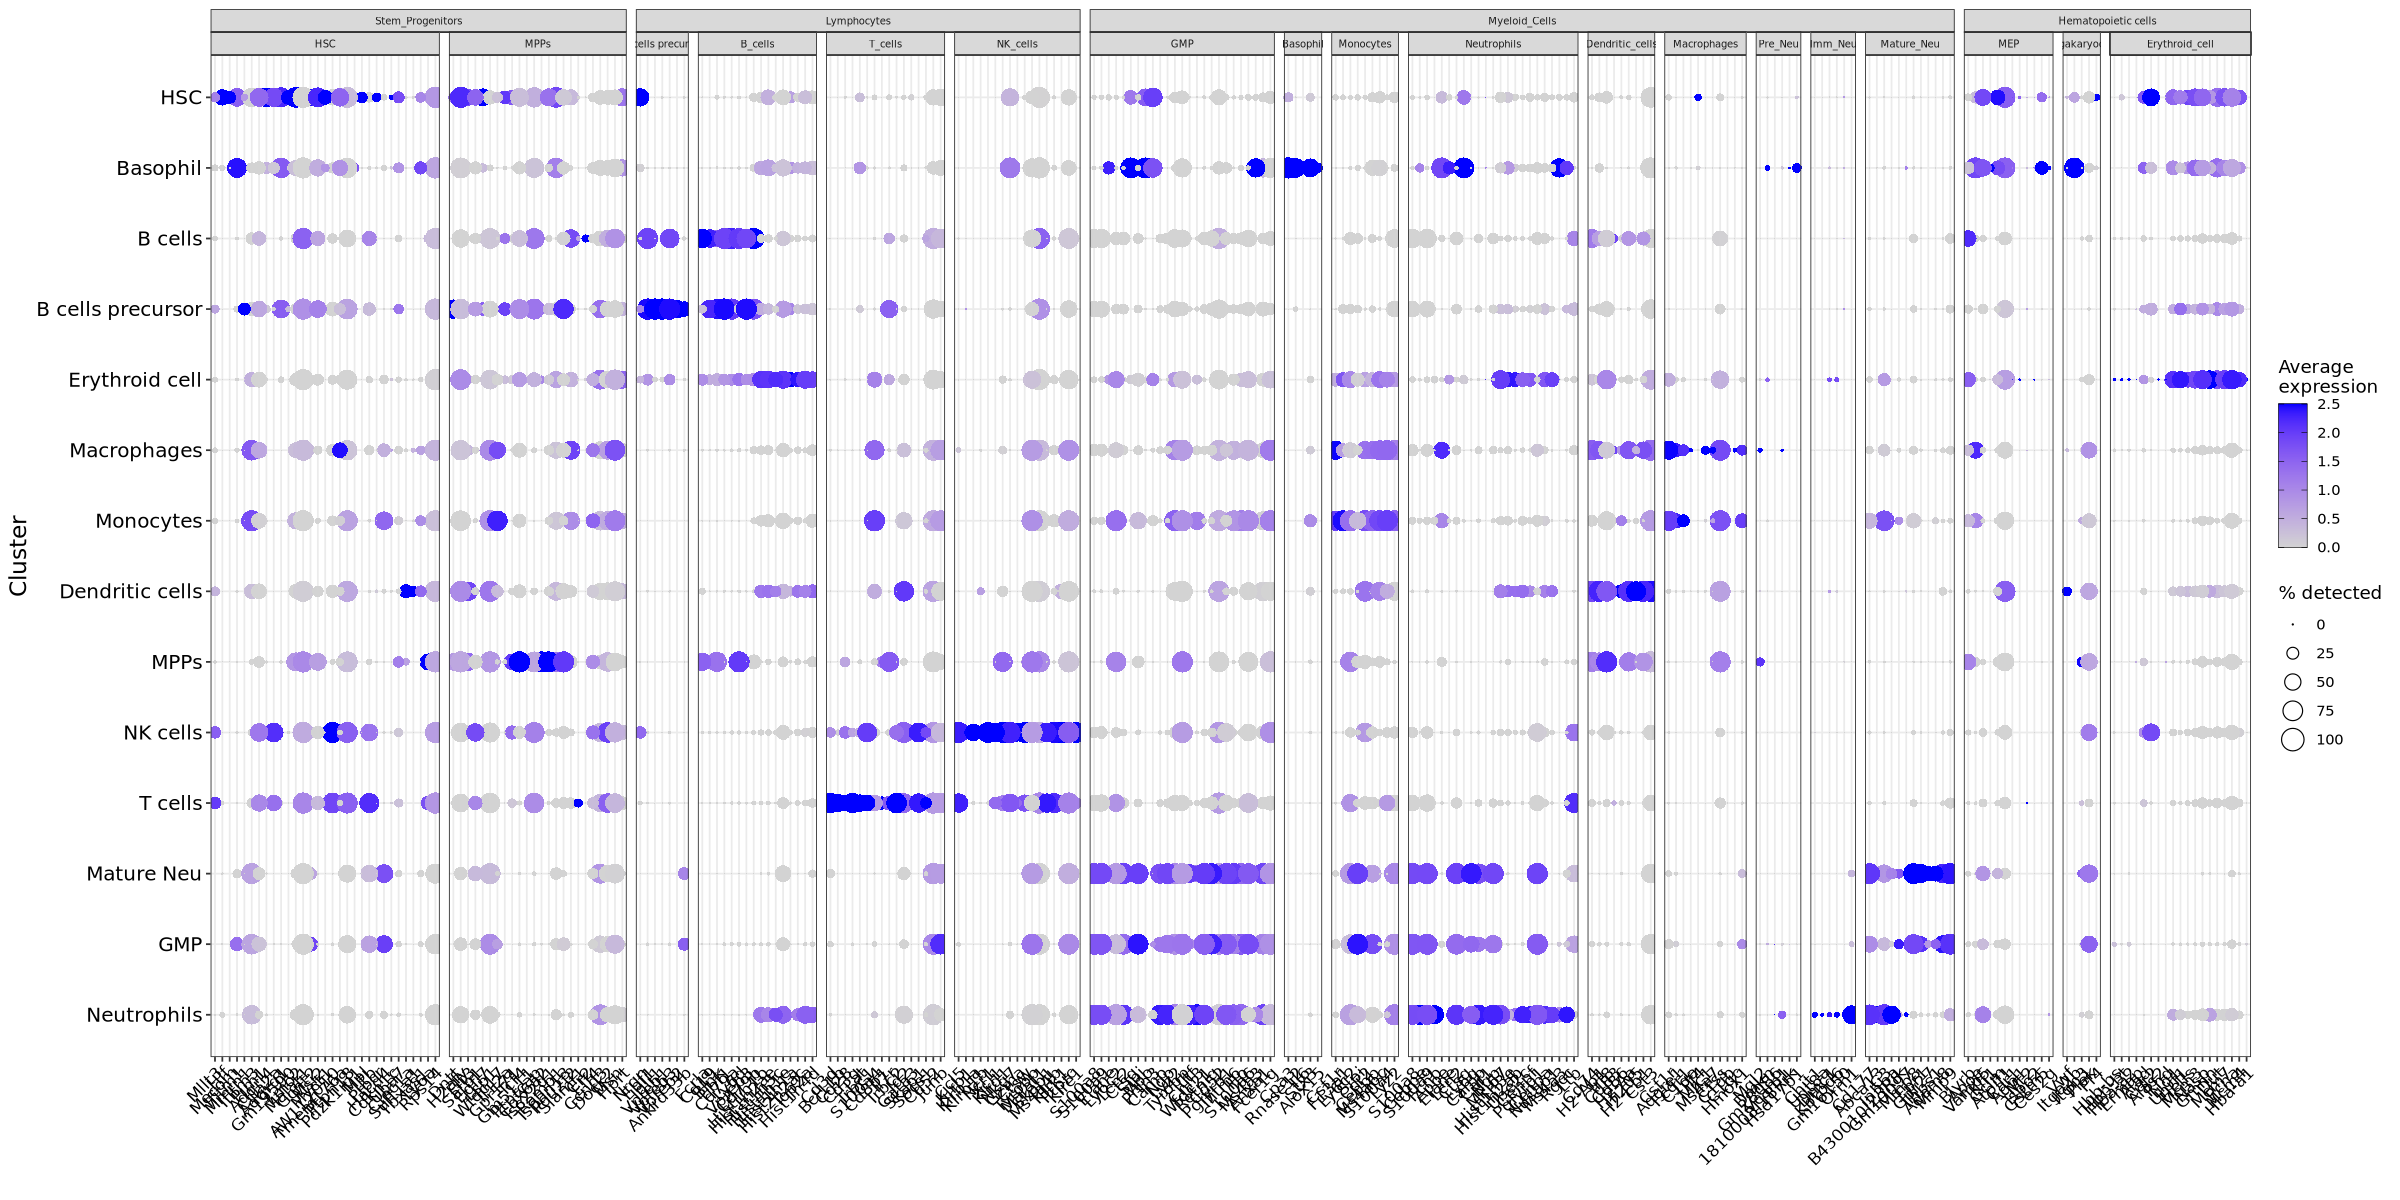

In [20]:
# Filter markers list for only genes present in the dataset
valid_features <- intersect(cell.markers$marker, rownames(adata[["SCT"]]))
g = DotPlot(adata, assay='SCT', features=valid_features, cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=20, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 6),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
    figure

In [21]:
meta_summary.aggreageted <- aggregate(meta_summary$avg.exp,by=list(Compartment=meta_summary$Compartment,
                                                                   CellType=meta_summary$CellType,
                                                                   id = meta_summary$id),FUN=sum)
colnames(meta_summary.aggreageted)[ncol(meta_summary.aggreageted)] = "aggregated.expr"
max(meta_summary.aggreageted$aggregated.expr)

[1] 3752.032

In [22]:
max.use = 4000

In [23]:
gg3 = ggplot(meta_summary.aggreageted, aes(x = aggregated.expr, y = id)) +
theme_bw() +
  geom_col() +
      xlim(0,max.use)+
      theme(axis.text = element_text(size = 10),
            axis.text.x = element_text(size = 10, angle = 90, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      ylab("Cluster_ID \n") + xlab("\n Agr.exp") +
facet_nested(cols = vars(CellType),
             scales = "free", space = "free_y")

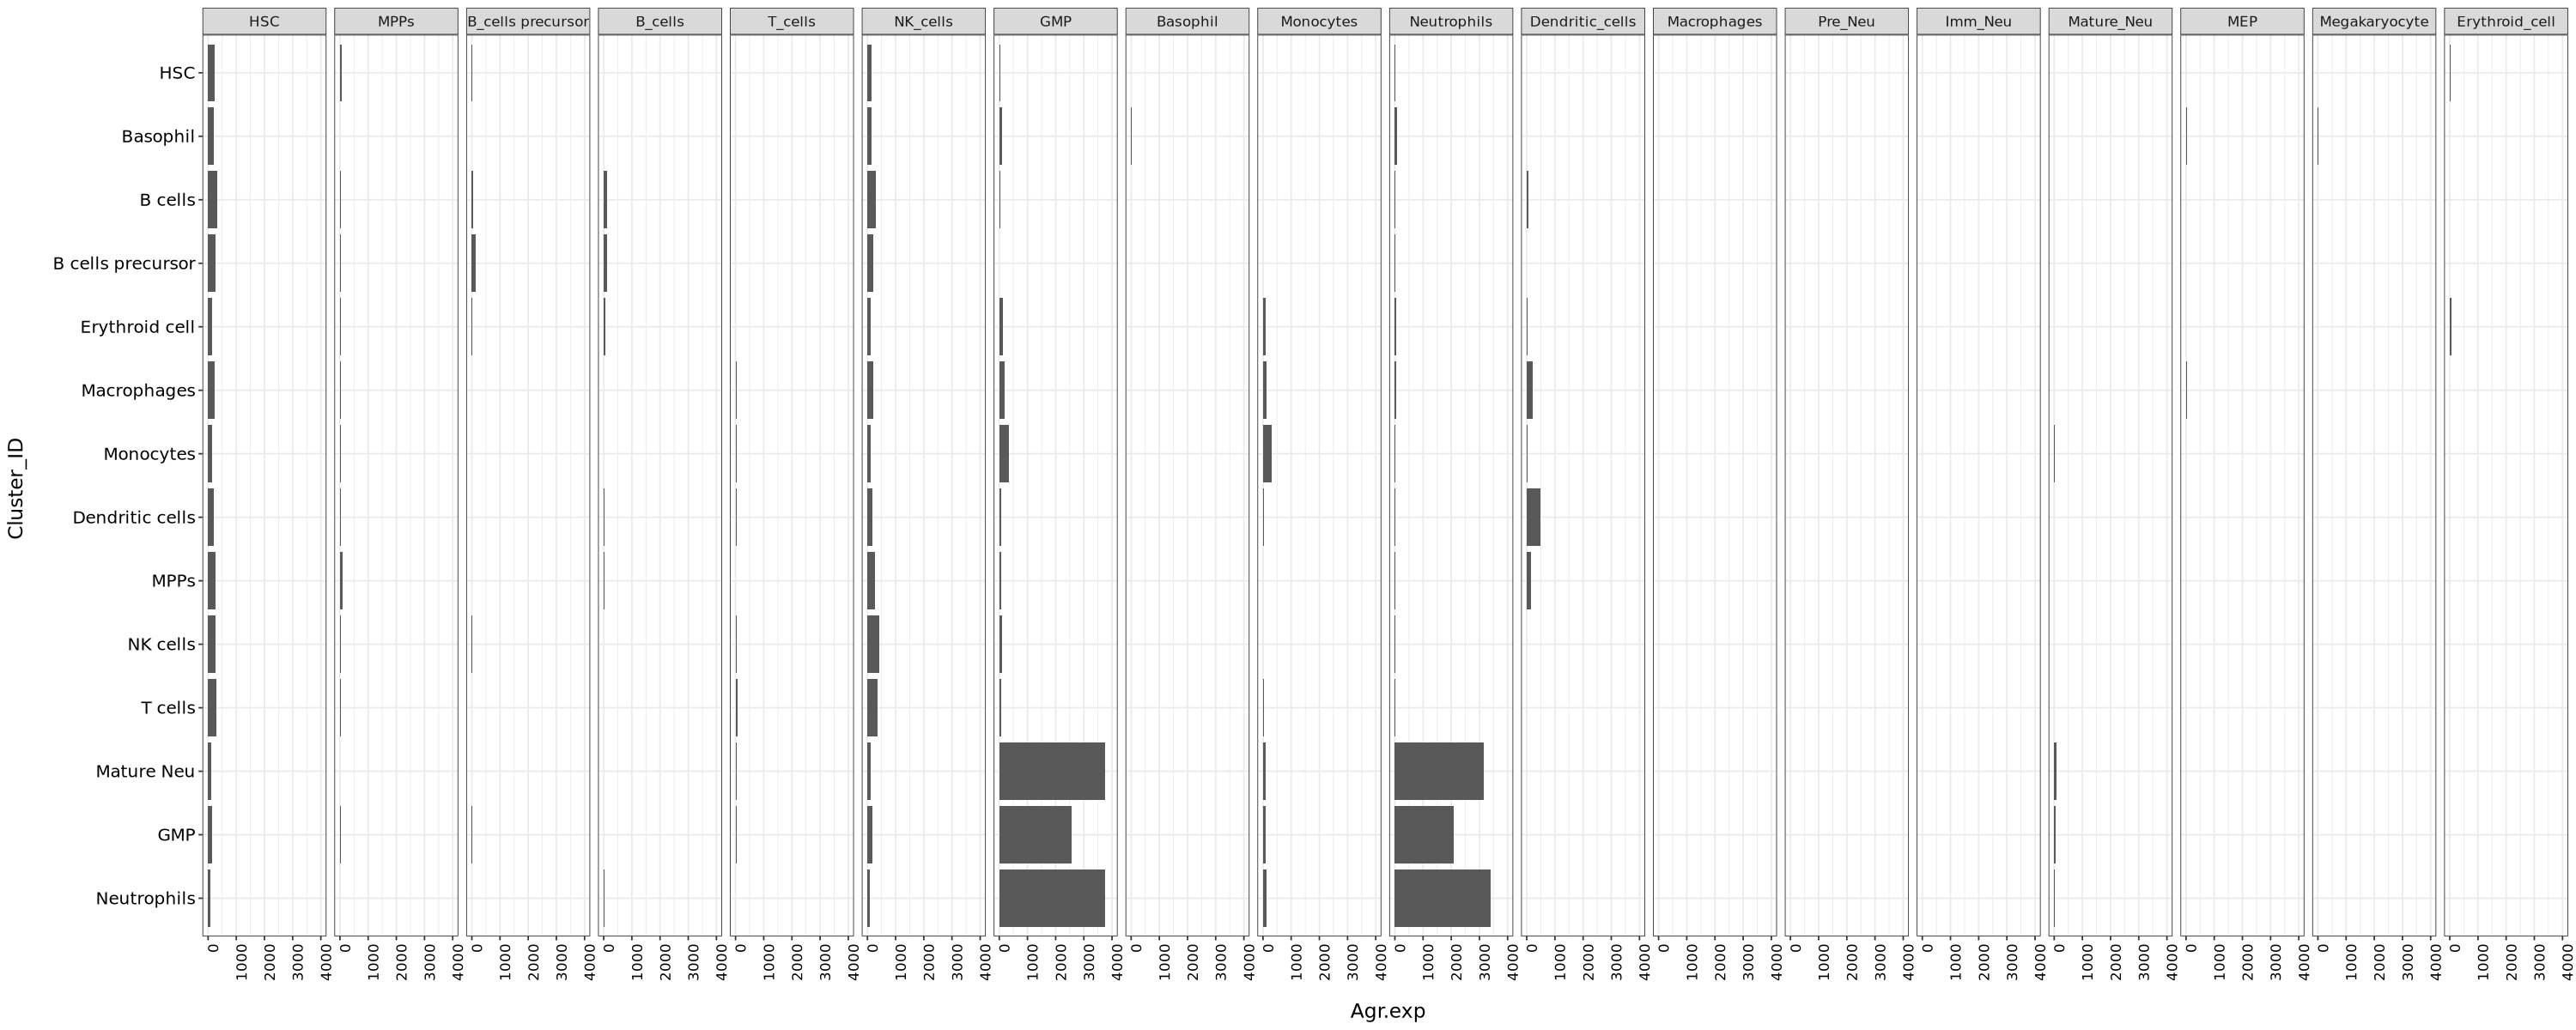

In [24]:
options(repr.plot.width=25, repr.plot.height=10)
gg3

# Manual curation

In [25]:
# Add metadata
samples = c("1_GFP1", "2_GFP2", "3_GFP3",
           "4_RBD1", "5_RBD2", "6_RBD3",
           "10_G1C1", "11_G1C2", "12_G1C3")
conditions = c("GFP", "GFP", "GFP",
             "RBD", "RBD", "RBD",
             "G1C", "G1C", "G1C")
meta = data.frame(library = samples, condition = conditions)
adata$condition <- meta$condition[match(adata$library, meta$library)]

table(adata$condition, adata$library)

     
      1_GFP1 10_G1C1 11_G1C2 12_G1C3 2_GFP2 3_GFP3 4_RBD1 5_RBD2 6_RBD3
  G1C      0   13984   14886   12925      0      0      0      0      0
  GFP  10697       0       0       0  13047  15333      0      0      0
  RBD      0       0       0       0      0      0  13146  13361   8803

In [26]:
adata$celltypes = adata$customclassif
unique(adata$celltypes)

[1] "GMP"               "MPPs"              "Monocytes"        
 [4] "Mature Neu"        "B cells precursor" "Macrophages"      
 [7] "Dendritic cells"   "B cells"           "Erythroid cell"   
[10] "T cells"           "Neutrophils"       "Basophil"         
[13] "HSC"               "NK cells"

In [28]:
file = paste(step5.dir, "snRNAseq_mrg.clean.scTyped.rds", sep = "")
saveRDS(adata, file = file)